--------------------------------------------------------------------------------------------------------------------

## Explainable AI for phishing emails detection

--------------------------------------------------------------------------------------------------------------------

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, GRU, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
# ml and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import LabelEncoder

In [4]:
# Visualization
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

--------------------------------------------------------------------------------------------------------------------

#### Loading data

In [5]:
df1 = pd.read_csv("C:/Users/Dell/Desktop/XAI_Model/SpamAssasin.csv")
df2 = pd.read_csv("C:/Users/Dell/Desktop/XAI_Model/CEAS_08.csv")

In [6]:
df = pd.concat([df1, df2], ignore_index=True)

In [7]:
df.head()

,sender,receiver,date,subject,body,label,urls
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44963 entries, 0 to 44962
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    44963 non-null  object
 1   receiver  44291 non-null  object
 2   date      44963 non-null  object
 3   subject   44919 non-null  object
 4   body      44962 non-null  object
 5   label     44963 non-null  int64 
 6   urls      44963 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.4+ MB


--------------------------------------------------------------------------------------------------------------------

#### Data Cleaning

In [9]:
df.isnull().sum()

sender        0
receiver    672
date          0
subject      44
body          1
label         0
urls          0
dtype: int64

In [10]:
df.dropna(subset=['receiver', 'subject', 'body', 'label'], inplace=True)

In [11]:
def advanced_text_cleaning(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # remove  email headers and metadata
    text = re.sub(r'(from:|to:|subject:|date:|reply-to:|message-id:).*?\n', '', text)
    # remove HTML tags 
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Handle URLs (preserve them as they're important for phishing detection)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' URL_TOKEN ', text)
    
    # for email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', ' EMAIL_TOKEN ', text)
    # for phone numbers
    text = re.sub(r'[\+]?[1-9]?[0-9]{7,15}', ' PHONE_TOKEN ', text)
    
    # remove excess punctuation
    text = re.sub(r'[!]{3,}', ' MULTIPLE_EXCLAMATION ', text)
    text = re.sub(r'[\?]{3,}', ' MULTIPLE_QUESTION ', text)
    text = re.sub(r'[$]{2,}', ' MULTIPLE_DOLLAR ', text)
    # other special characters
    text = re.sub(r'[^a-zA-Z0-9\s!?$.]', ' ', text)
    # excess whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [12]:
# cleaning
df['subject_clean'] = df['subject'].apply(advanced_text_cleaning)
df['body_clean'] = df['body'].apply(advanced_text_cleaning)

In [13]:
df['text'] = df['subject_clean'].fillna('') + ' ' + df['body_clean'].fillna('')
df['label'] = df['label'].apply(lambda x: 1 if x == 1 else 0)

In [14]:
print(f"Before cleaning, dataset shape: {df.shape}")

Before cleaning, dataset shape: (44251, 10)


In [15]:
duplicate_rows = df.duplicated()
duplicate_count = duplicate_rows.sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


In [16]:
df = df[df['text'].str.len() > 10]  # Remove very short texts
df.dropna(subset=['receiver', 'subject', 'body', 'text', 'label'], inplace=True)
print(f"After cleaning: {len(df)} samples")

After cleaning: 44251 samples


##### now our data is totally clean!

--------------------------------------------------------------------------------------------------------------------

#### Exploratory Data Analysis

In [17]:
# Text length analysis
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

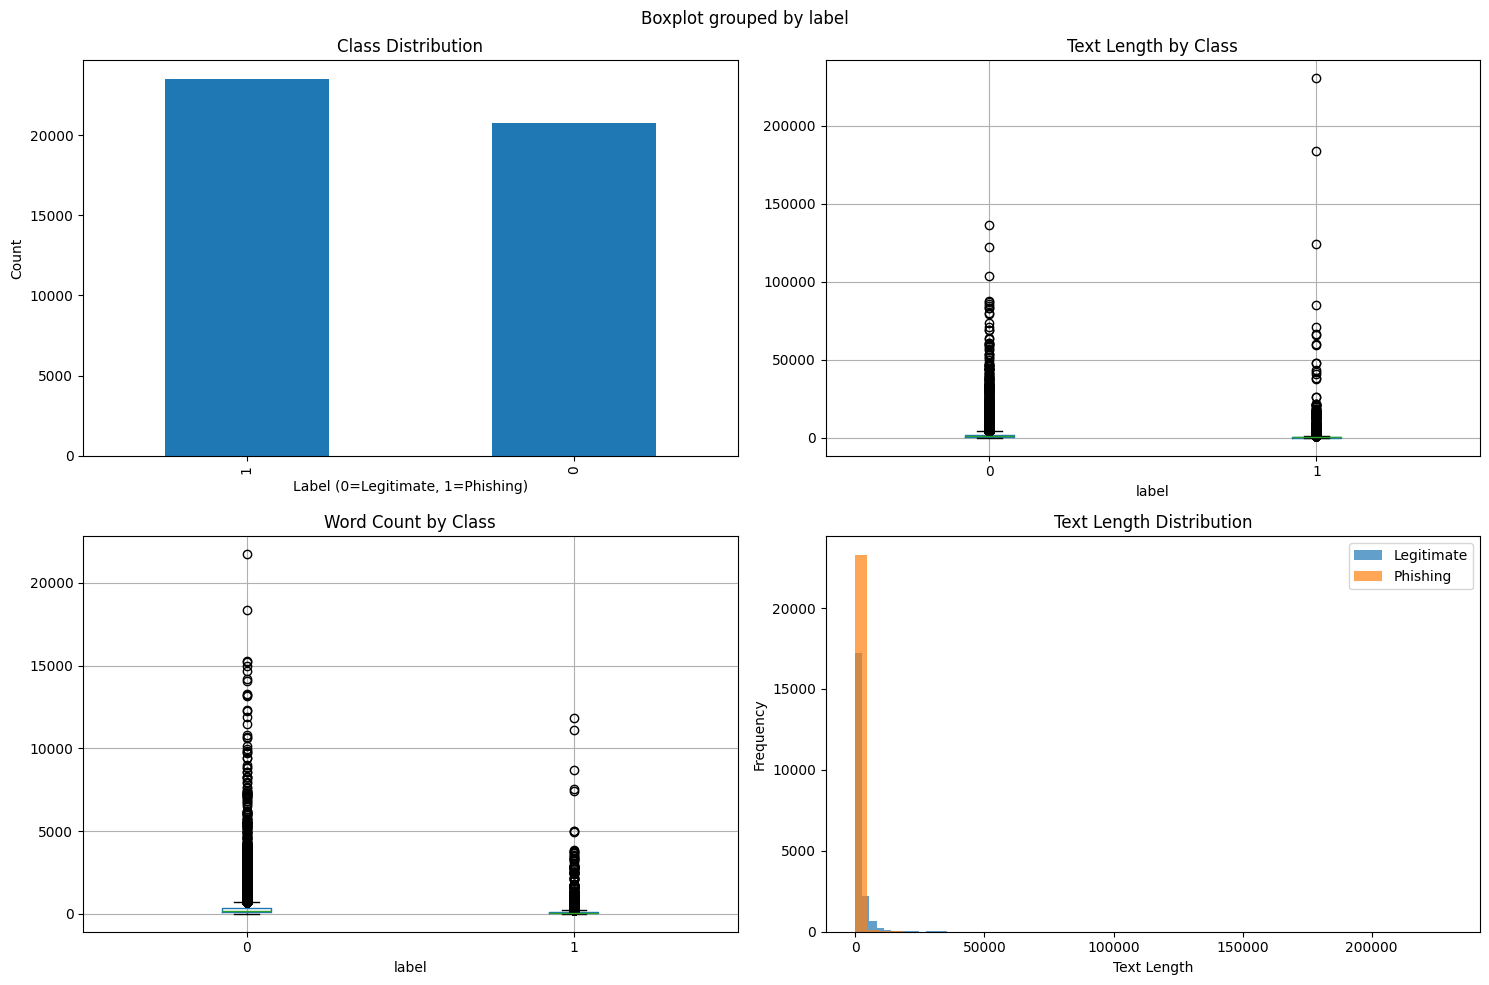

In [18]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Class distribution
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], title='Class Distribution')
axes[0,0].set_xlabel('Label (0=Legitimate, 1=Phishing)')
axes[0,0].set_ylabel('Count')

# Text length distribution
df.boxplot(column='text_length', by='label', ax=axes[0,1])
axes[0,1].set_title('Text Length by Class')

# Word count distribution
df.boxplot(column='word_count', by='label', ax=axes[1,0])
axes[1,0].set_title('Word Count by Class')

# Text length histogram
axes[1,1].hist(df[df['label']==0]['text_length'], alpha=0.7, label='Legitimate', bins=50)
axes[1,1].hist(df[df['label']==1]['text_length'], alpha=0.7, label='Phishing', bins=50)
axes[1,1].set_xlabel('Text Length')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Text Length Distribution')
axes[1,1].legend()

plt.tight_layout()
plt.show()

##### from above you can see that spammy emails have less word count

##### also, the text length in spam emails is more

In [19]:
# optimal sequence length
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    length = np.percentile(df['word_count'], p)
    print(f"{p}th percentile word count: {length:.0f}")

50th percentile word count: 100
75th percentile word count: 262
90th percentile word count: 435
95th percentile word count: 706
99th percentile word count: 2108


--------------------------------------------------------------------------------------------------------------------

#### Feature Engineering for XAI

In [20]:
def extract_email_features(df):
    features = pd.DataFrame()
    
    # basic text features
    features['char_count'] = df['text'].str.len()
    features['word_count'] = df['text'].str.split().str.len()
    features['sentence_count'] = df['text'].str.count(r'[.!?]+')
    features['avg_word_length'] = features['char_count'] / features['word_count']
    
    # punctuation and special characters
    features['exclamation_count'] = df['text'].str.count('!')
    features['question_count'] = df['text'].str.count('\?')
    features['dollar_count'] = df['text'].str.count('\$')
    
    # capital letters
    features['capital_count'] = df['text'].str.count(r'[A-Z]')
    features['capital_ratio'] = features['capital_count'] / features['char_count']
    
    # suspicious words
    suspicious_words = ['urgent', 'immediate', 'act now', 'limited time', 'click here', 
                        'free', 'winner', 'prize', 'verify', 'confirm', 'suspended']
    
    for word in suspicious_words:
        features[f'contains_{word.replace(" ", "_")}'] = df['text'].str.lower().str.contains(word).astype(int)
    
    # url/email features
    features['url_count'] = df['urls']
    features['has_url'] = (features['url_count'] > 0).astype(int)
    # email-specific patterns
    features['has_attachment'] = df['text'].str.contains('attachment', case=False).astype(int)
    
    return features

In [21]:
feature_df = extract_email_features(df)

In [22]:
# add back to main df
for col in feature_df.columns:
    df[f'feat_{col}'] = feature_df[col]

In [23]:
# Feature correlation with label
feature_cols = [col for col in df.columns if col.startswith('feat_')]
correlations = df[feature_cols + ['label']].corr()['label'].sort_values(ascending=False)

In [24]:
print(correlations)

label                         1.000000
feat_capital_ratio            0.240431
feat_contains_click_here      0.178727
feat_avg_word_length          0.126078
feat_contains_suspended       0.052105
feat_contains_act_now         0.017466
feat_contains_urgent          0.017201
feat_contains_limited_time    0.007016
feat_exclamation_count       -0.011154
feat_url_count               -0.015245
feat_has_url                 -0.015245
feat_contains_prize          -0.040232
feat_contains_free           -0.040406
feat_capital_count           -0.044348
feat_dollar_count            -0.048104
feat_contains_winner         -0.050645
feat_contains_immediate      -0.051145
feat_contains_verify         -0.065972
feat_has_attachment          -0.108106
feat_contains_confirm        -0.109752
feat_char_count              -0.188146
feat_question_count          -0.191317
feat_sentence_count          -0.197060
feat_word_count              -0.221959
Name: label, dtype: float64


--------------------------------------------------------------------------------------------------------------------

#### Train-test split

In [25]:
# texts and labels
texts = df['text'].tolist()
labels = df['label'].values

print(f"Total samples: {len(texts)}")
print(f"Class distribution: {np.bincount(labels)}")

Total samples: 44251
Class distribution: [20766 23485]


In [26]:
# Train-test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

In [27]:
# further splitting data for validation
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train samples: {len(X_train_text)}")
print(f"Validation samples: {len(X_val_text)}")
print(f"Test samples: {len(X_test_text)}")

Train samples: 28320
Validation samples: 7080
Test samples: 8851


--------------------------------------------------------------------------------------------------------------------

In [28]:
X_train_text[0]

'you gonna love this suffering from short penniss? introduce revolution manxl formula which gauranteees sizes increase or moneey baack. users reported 2 inches extra in size 3x pleasurable orgasms 27 thicker why waiting? URL TOKEN'

#### Tokenization and Sequence Preparation

In [29]:
# Tokenization params
MAX_WORDS = 15000  # Increased vocab
MAX_LEN = 400      # Based on EDA results

In [30]:
# Tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

In [31]:
# texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

In [32]:
# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Training sequences shape: {X_train_pad.shape}")
print(f"Validation sequences shape: {X_val_pad.shape}")
print(f"Test sequences shape: {X_test_pad.shape}")

Training sequences shape: (28320, 400)
Validation sequences shape: (7080, 400)
Test sequences shape: (8851, 400)


In [33]:
# Save tokenizer for later use
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

Vocabulary size: 150891


--------------------------------------------------------------------------------------------------------------------

#### CNN-BiGRU Model Architecture

In [34]:
def create_cnn_bigru_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_length, name='embedding'),
        
        # CNN branch
        Conv1D(128, 3, activation='relu', name='conv1d_1'),
        MaxPooling1D(2, name='maxpool_1'),
        Conv1D(64, 4, activation='relu', name='conv1d_2'),
        MaxPooling1D(2, name='maxpool_2'),
        
        # BiGRU branch
        Bidirectional(GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3), name='bigru_1'),
        Bidirectional(GRU(32, dropout=0.3, recurrent_dropout=0.3), name='bigru_2'),
        
        # Dense layers
        Dense(64, activation='relu', name='dense_1'),
        Dropout(0.5, name='dropout_1'),
        Dense(32, activation='relu', name='dense_2'),
        Dropout(0.3, name='dropout_2'),
        
        # Output layer
        Dense(1, activation='sigmoid', name='output')
    ])
    
    return model

In [35]:
# Model parameters
EMBEDDING_DIM = 128
VOCAB_SIZE = min(MAX_WORDS, len(word_index) + 1)

In [36]:
# create model
model = create_cnn_bigru_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN)

In [37]:
# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

--------------------------------------------------------------------------------------------------------------------

#### Model training

In [38]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    ),
    
    ModelCheckpoint(
        'best_cnn_bigru_model.h5', monitor='val_loss', save_best_only=True, verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
    )
]

In [39]:
# Train model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.8484 - loss: 0.2861 - precision: 0.8696 - recall: 0.8313
Epoch 1: val_loss improved from inf to 0.02989, saving model to best_cnn_bigru_model.h5


443/443 ━━━━━━━━━━━━━━━━━━━━ 397s 805ms/step - accuracy: 0.8486 - loss: 0.2857 - precision: 0.8698 - recall: 0.8316 - val_accuracy: 0.9911 - val_loss: 0.0299 - val_precision: 0.9897 - val_recall: 0.9936 - learning_rate: 0.0010
Epoch 2/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.9956 - loss: 0.0177 - precision: 0.9959 - recall: 0.9959
Epoch 2: val_loss improved from 0.02989 to 0.02903, saving model to best_cnn_bigru_model.h5


443/443 ━━━━━━━━━━━━━━━━━━━━ 348s 786ms/step - accuracy: 0.9956 - loss: 0.0177 - precision: 0.9959 - recall: 0.9959 - val_accuracy: 0.9918 - val_loss: 0.0290 - val_precision: 0.9907 - val_recall: 0.9939 - learning_rate: 0.0010
Epoch 3/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.9989 - loss: 0.0052 - precision: 0.9989 - recall: 0.9990
Epoch 3: val_loss did not improve from 0.02903
443/443 ━━━━━━━━━━━━━━━━━━━━ 352s 794ms/step - accuracy: 0.9989 - loss: 0.0052 - precision: 0.9989 - recall: 0.9990 - val_accuracy: 0.9907 - val_loss: 0.0381 - val_precision: 0.9952 - val_recall: 0.9872 - learning_rate: 0.0010
Epoch 4/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.9986 - loss: 0.0045 - precision: 0.9986 - recall: 0.9988
Epoch 4: val_loss did not improve from 0.02903
443/443 ━━━━━━━━━━━━━━━━━━━━ 358s 807ms/step - accuracy: 0.9986 - loss: 0.0045 - precision: 0.9986 - recall: 0.9988 - val_accuracy: 0.9905 - val_loss: 0.0532 - val_precision: 0.9941 - val_recall: 0.9880

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 400, 128)            │       1,920,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 398, 128)            │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling1D)             │ (None, 199, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 196, 64)             │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling1D)             │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bigru_1 (Bidirectional)              │ (None, 98, 128)             │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bigru_2 (Bidirectional)              │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,268,229 (23.91 MB)

 Trainable params: 2,089,409 (7.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,178,820 (15.94 MB)

##### model is a bit overcomplex

--------------------------------------------------------------------------------------------------------------------

#### Training History Visualization

In [41]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0,0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0,0].set_title('Model Accuracy')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    
    # Loss
    axes[0,1].plot(history.history['loss'], label='Training Loss')
    axes[0,1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0,1].set_title('Model Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    
    # Precision
    axes[1,0].plot(history.history['precision'], label='Training Precision')
    axes[1,0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1,0].set_title('Model Precision')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].legend()
    
    # Recall
    axes[1,1].plot(history.history['recall'], label='Training Recall')
    axes[1,1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1,1].set_title('Model Recall')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Recall')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

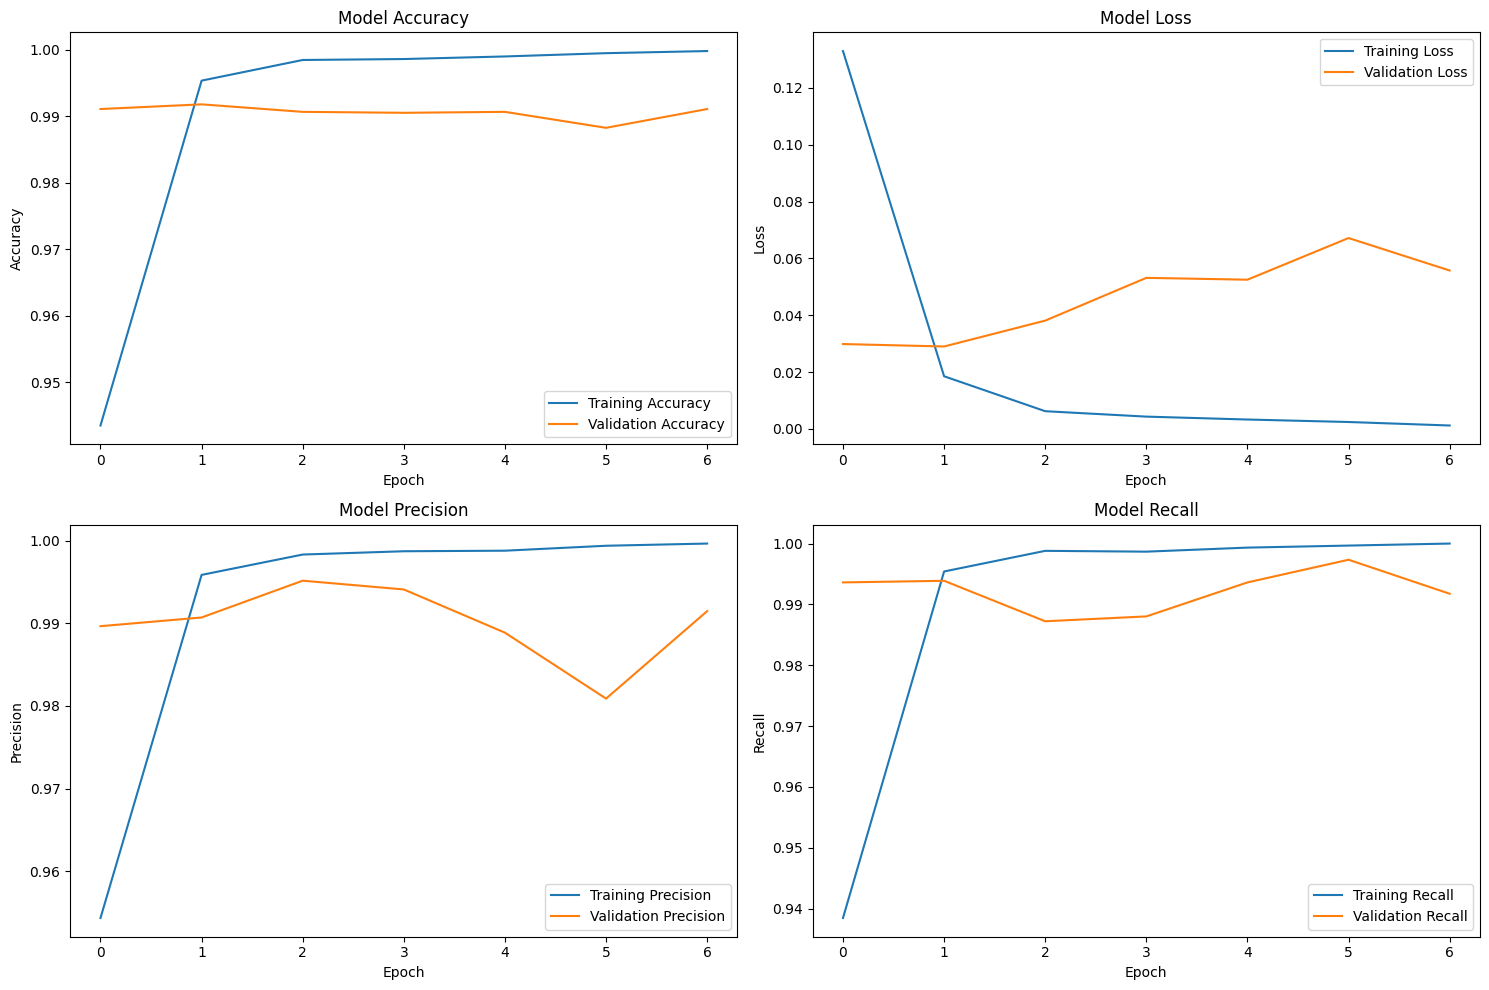

In [42]:
plot_training_history(history)

##### the curves are smooth and dont hint at overfitting. Good to go!

--------------------------------------------------------------------------------------------------------------------

#### Model evaluation

In [43]:
def evaluate_model(model, X_test, y_test, X_test_text):
    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print("CNN-BiGRU Model Performance:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

277/277 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
CNN-BiGRU Model Performance:
Accuracy:  0.9914
Precision: 0.9890
Recall:    0.9949
F1-Score:  0.9919
AUC-ROC:   0.9995


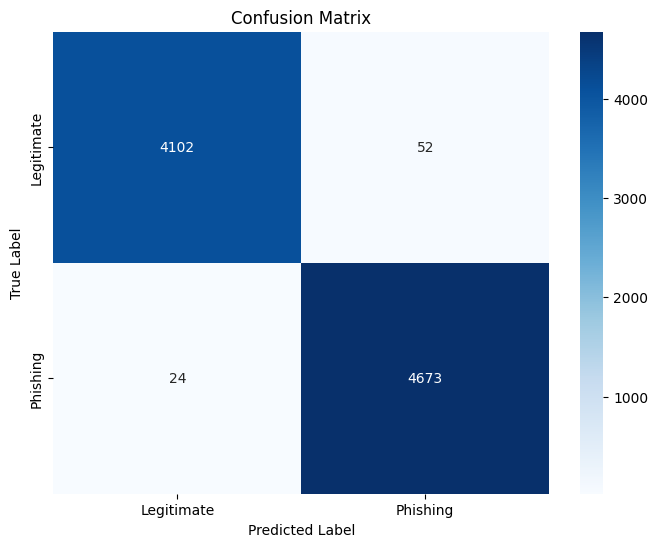


Detailed Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99      4154
    Phishing       0.99      0.99      0.99      4697

    accuracy                           0.99      8851
   macro avg       0.99      0.99      0.99      8851
weighted avg       0.99      0.99      0.99      8851



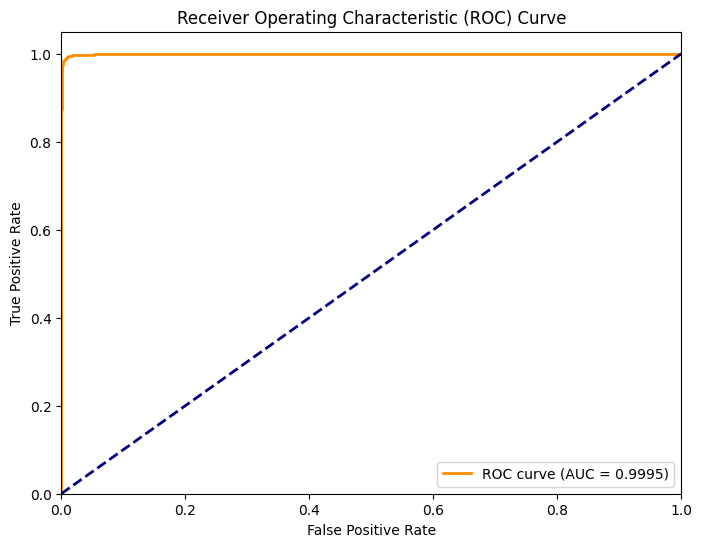

In [44]:
# Evaluate model
results = evaluate_model(model, X_test_pad, y_test, X_test_text)

--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------

####  SHAP Integration and Analysis

In [45]:
def c_prediction_wrapper(model, tokenizer, max_len):
    def predict_wrapper(texts):
        if isinstance(texts, str):
            texts = [texts]
        elif isinstance(texts, np.ndarray):
            texts = texts.tolist()
        
        sequences = tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
        predictions = model.predict(padded_sequences, verbose=0)
        
        prob_legitimate = 1 - predictions.flatten()
        prob_phishing = predictions.flatten()
        return np.column_stack([prob_legitimate, prob_phishing])
    
    return predict_wrapper

In [46]:
predict_wrapper = c_prediction_wrapper(model, tokenizer, MAX_LEN)

In [47]:
print("Testing prediction wrapper...")
test_texts = X_test_text[:3]
test_predictions = predict_wrapper(test_texts)
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Sample predictions:\n{test_predictions}")

Testing prediction wrapper...
Test predictions shape: (3, 2)
Sample predictions:
[[9.9304891e-01 6.9510918e-03]
 [1.3113022e-05 9.9998689e-01]
 [9.9998790e-01 1.2120993e-05]]


In [48]:
def setup_shap_text_explainer(prediction_function, background_texts=None, max_background=50):
    if background_texts is None:
        # using subset of training texts as background
        background_texts = X_train_text[:max_background]
    
    # SHAP text explainer
    explainer = shap.Explainer(prediction_function, background_texts)
    print("SHAP Text Explainer set...")    
    return explainer

In [49]:
import shap
from shap import maskers

# first define Text Masker
text_masker = shap.maskers.Text()
# then Explainer for text
shap_explainer = shap.Explainer(predict_wrapper, text_masker)

In [50]:
def explain_with_shap(explainer, test_texts, test_labels, num_samples=6, random_seed=42):    
    print(f"Generating SHAP explanations for {num_samples} samples...")
    np.random.seed(random_seed)

    legitimate_indices = np.where(test_labels == 0)[0]
    phishing_indices = np.where(test_labels == 1)[0]

    n_per_class = num_samples // 2
    selected_legitimate = np.random.choice(legitimate_indices, n_per_class, replace=False)
    selected_phishing = np.random.choice(phishing_indices, num_samples - n_per_class, replace=False)
    selected_indices = np.concatenate([selected_legitimate, selected_phishing])

    selected_texts = [test_texts[i] for i in selected_indices]
    selected_labels = [test_labels[i] for i in selected_indices]

    print("Computing SHAP values...")
    shap_values = explainer(selected_texts)

    predictions = predict_wrapper(selected_texts)

    explanations = []
    for i, idx in enumerate(selected_indices):
        explanations.append({
            'sample_idx': idx,
            'text': selected_texts[i],
            'true_label': selected_labels[i],
            'true_label_name': 'Legitimate' if selected_labels[i] == 0 else 'Phishing',
            'predicted_proba': predictions[i],
            'predicted_class': np.argmax(predictions[i]),
            'predicted_class_name': 'Legitimate' if np.argmax(predictions[i]) == 0 else 'Phishing',
            'confidence': np.max(predictions[i]),
            'shap_values': shap_values[i],
            'correct_prediction': selected_labels[i] == np.argmax(predictions[i])
        })

    return explanations, shap_values

In [51]:
# generating SHAP explanations....
shap_explanations, shap_values = explain_with_shap(
    shap_explainer, X_test_text, y_test, num_samples=6, random_seed=42
)

Generating SHAP explanations for 6 samples...
Computing SHAP values...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|██████████▎                                                   | 1/6 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████████████████████████                        | 3/6 [1:11:58<1:46:59, 2139.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|████████████████████████████████                | 4/6 [5:04:04<3:55:01, 7050.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████████████████████████████████████        | 5/6 [5:04:31<1:13:49, 4429.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████████████████████████████████████████████| 6/6 [5:04:57<00:00, 2898.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 7it [5:05:22, 3053.69s/it]                                                               


In [52]:
print(f"\nGenerated explanations for {len(shap_explanations)} samples:")
for i, exp in enumerate(shap_explanations):
    print(f"Sample {i+1}: True={exp['true_label_name']}, Predicted={exp['predicted_class_name']}, "
          f"Confidence={exp['confidence']:.3f}, Correct={exp['correct_prediction']}")


Generated explanations for 6 samples:
Sample 1: True=Legitimate, Predicted=Legitimate, Confidence=1.000, Correct=True
Sample 2: True=Legitimate, Predicted=Legitimate, Confidence=1.000, Correct=True
Sample 3: True=Legitimate, Predicted=Legitimate, Confidence=1.000, Correct=True
Sample 4: True=Phishing, Predicted=Phishing, Confidence=1.000, Correct=True
Sample 5: True=Phishing, Predicted=Phishing, Confidence=1.000, Correct=True
Sample 6: True=Phishing, Predicted=Phishing, Confidence=0.999, Correct=True


#### SHAP INFERENCE

In [53]:
import pandas as pd
import numpy as np
import re
import shap
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# === 1. preprocessing/cleaning===
def advanced_text_cleaning(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'(from:|to:|subject:|date:|reply-to:|message-id:).*?\n', '', text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http[s]?://\S+', ' URL_TOKEN ', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', ' EMAIL_TOKEN ', text)
    text = re.sub(r'[\+]?[1-9]?[0-9]{7,15}', ' PHONE_TOKEN ', text)
    text = re.sub(r'[!]{3,}', ' MULTIPLE_EXCLAMATION ', text)
    text = re.sub(r'[\?]{3,}', ' MULTIPLE_QUESTION ', text)
    text = re.sub(r'[$]{2,}', ' MULTIPLE_DOLLAR ', text)
    text = re.sub(r'[^a-zA-Z0-9\s!?$.]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# === 2. feature engineering===
def extract_email_features_row(text, url_count=0):
    features = {}
    features['char_count'] = len(text)
    features['word_count'] = len(text.split())
    features['sentence_count'] = text.count('.') + text.count('!') + text.count('?')
    features['avg_word_length'] = features['char_count'] / (features['word_count'] + 1e-5)
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['dollar_count'] = text.count('$')
    features['capital_count'] = sum(1 for c in text if c.isupper())
    features['capital_ratio'] = features['capital_count'] / (features['char_count'] + 1e-5)
    
    suspicious_words = ['urgent', 'immediate', 'act now', 'limited time', 'click here', 
                        'free', 'winner', 'prize', 'verify', 'confirm', 'suspended']
    for word in suspicious_words:
        features[f'contains_{word.replace(" ", "_")}'] = int(word in text)
    
    features['url_count'] = url_count
    features['has_url'] = int(url_count > 0)
    features['has_attachment'] = int('attachment' in text.lower())
    
    return pd.DataFrame([features])

In [54]:
def make_inference_pipeline(model, tokenizer, max_len, explainer, row, return_shap=True):
    subject_clean = advanced_text_cleaning(row['subject'])
    body_clean = advanced_text_cleaning(row['body'])
    full_text = subject_clean + ' ' + body_clean

    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([full_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Predict
    prediction = model.predict(padded_sequence, verbose=0)[0][0]
    predicted_class = int(prediction > 0.5)
    confidence = prediction if predicted_class == 1 else 1 - prediction

    result = {
        "text": full_text,
        "predicted_class": predicted_class,
        "confidence": confidence,
        "probabilities": [1 - prediction, prediction],
    }

    # SHAP explanation
    if return_shap:
        shap_values = explainer([full_text])
        result["shap_values"] = shap_values[0]  # single explanation

    return result

In [55]:
# any row from our DataFrame
sample_row = df.iloc[0]

In [56]:
sample_row

sender                                           Robert Elz <kre@munnari.OZ.AU>
receiver                      Chris Garrigues <cwg-dated-1030377287.06fa6d@D...
date                                            Thu, 22 Aug 2002 18:26:25 +0700
subject                                                Re: New Sequences Window
body                          Date:        Wed, 21 Aug 2002 10:54:46 -0500  ...
label                                                                         0
urls                                                                          1
subject_clean                                           re new sequences window
body_clean                    date wed 21 aug 2002 10 54 46 0500 from chris ...
text                          re new sequences window date wed 21 aug 2002 1...
text_length                                                                1319
word_count                                                                  258
feat_char_count                         

In [57]:
import shap
from shap.maskers import Text

text_masker = Text(tokenizer=None)  # raw string input, so tokenizer=None
shap_explainer = shap.Explainer(predict_wrapper, masker=text_masker)

In [ ]:
result = make_inference_pipeline(
    model=model,
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    explainer=shap_explainer,
    row=sample_row,
    return_shap=True
)

  0%|          | 0/498 [00:00<?, ?it/s]

In [ ]:
print(result)

In [ ]:
# output
print(f"Prediction: {'Phishing' if result['predicted_class'] == 1 else 'Legitimate'}")
print(f"Confidence: {result['confidence']:.3f}")
print(f"Probabilities: {result['probabilities']}")

In [ ]:
def visualize_single_shap_result(shap_values, text=None):
    if text:
        print(f"Visualizing explanation for: {text[:100]}...")
    shap.plots.text(shap_values)

visualize_single_shap_result(result['shap_values'], result['text'])

In [ ]:
# SHAP WATERFALL PLOTS (for detailed explanations)
def create_shap_waterfall_plots(explanations, max_samples=2, class_index=1):

    for i in range(min(len(explanations), max_samples)):
        exp = explanations[i]
        shap_values = exp['shap_values']

        print(f"\nWaterfall plot for sample {exp['sample_idx']}:")
        print(f"True: {exp['true_label_name']}, Predicted: {exp['predicted_class_name']}, Confidence: {exp['confidence']:.3f}")

        # if multiclass SHAP explanation
        if isinstance(shap_values, shap.Explanation):
            # Handle 2D shap_values.values
            if shap_values.values.ndim == 2:
                shap_val = shap.Explanation(
                    values=shap_values.values[:, class_index],
                    base_values=shap_values.base_values[class_index] if isinstance(shap_values.base_values, np.ndarray) else shap_values.base_values,
                    data=shap_values.data,
                    feature_names=shap_values.feature_names
                )
            else:
                shap_val = shap_values
        else:
            print("[!] Unexpected SHAP format.")
            continue

        # fixing to ensure it's a scalar (not one-element array)
        if isinstance(shap_val.base_values, np.ndarray):
            shap_val.base_values = float(shap_val.base_values.flatten()[0])

        shap.plots.waterfall(shap_val, max_display=20)

In [ ]:
# waterfall plots
create_shap_waterfall_plots(shap_explanations, max_samples=2, class_index=1)

--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------

#### LIME Integration with CNN-BiGRU

In [ ]:
import numpy as np
import pandas as pd
import re
from keras.preprocessing.sequence import pad_sequences
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

In [ ]:
# ---- LIMEwrapper: Returns probabilities for both classes ----
def lime_prediction_wrapper(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
    predictions = model.predict(padded)
    return np.hstack([(1 - predictions), predictions])  # Shape: (n_samples, 2)

In [ ]:
lime_explainer = LimeTextExplainer(class_names=['Legitimate', 'Phishing'])

In [ ]:
def lime_inference_pipeline(model, tokenizer, max_len, row, explainer):
    # Clean and prepare text
    subject_clean = advanced_text_cleaning(row['subject'])
    body_clean = advanced_text_cleaning(row['body'])
    full_text = subject_clean + ' ' + body_clean

    # Predict
    sequence = tokenizer.texts_to_sequences([full_text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = model.predict(padded, verbose=0)[0][0]
    predicted_class = int(prediction > 0.5)
    confidence = prediction if predicted_class == 1 else 1 - prediction

    # LIME explanation
    lime_exp = explainer.explain_instance(
        full_text,
        lime_prediction_wrapper,
        num_features=10,
        labels=[1]
    )

    return {
        'text': full_text,
        'predicted_class': predicted_class,
        'confidence': confidence,
        'probabilities': [1 - prediction, prediction],
        'lime_explanation': lime_exp
    }

In [ ]:
def visualize_lime_explanation(lime_explanation):
    lime_explanation.show_in_notebook(text=True)
    # or save as HTML:
    # lime_explanation.save_to_file('lime_explanation.html')

In [ ]:
sample_row = df.iloc[20010]

lime_result = lime_inference_pipeline(
    model=model,
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    row=sample_row,
    explainer=lime_explainer
)

In [ ]:
# result
print("Predicted Class:", lime_result['predicted_class'])
print("Confidence:", lime_result['confidence'])

In [ ]:
# Visualize
visualize_lime_explanation(lime_result['lime_explanation'])

##### inference within a minute!

--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------